In [34]:
import pdr
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from tqdm import tqdm

import cv2
from scipy.ndimage import gaussian_filter, label
from astropy.stats import sigma_clip

from skimage import restoration, morphology

from IPython.display import Image, display
import imageio

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)

In [ ]:
image_data = pdr.read('test_data/e23456/e23456-nd-ffull-b00-image-r.fits')
movie_data = pdr.read('test_data/e23456/e23456-nd-f0060-b00-movie-r.fits')
#np.shape(movie),np.shape(image)
image = image_data['COUNT']
exptime = image_data['COUNT_HEADER']['XPOSURE']
movie = movie_data['COUNT']
exptimes = [movie_data['COUNT_HEADER'][f'EXPT_{i}'] for i in range(movie_data['COUNT_HEADER']['NAXIS3'])]


100%|██████████| 29/29 [00:16<00:00,  1.73it/s]


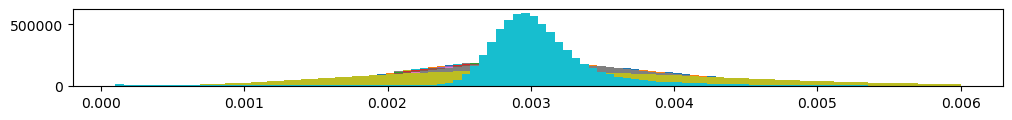

In [3]:
plt.figure(figsize=(12,1))
for i in tqdm(range(len(movie))):
    plt.hist(gaussian_filter(movie[i], sigma=3).flatten()/exptimes[i],bins=100,range=(0.0001,0.006));
plt.hist(gaussian_filter(image, sigma=3).flatten()/exptime,bins=100,range=(0.0001,0.006));

100%|██████████| 29/29 [00:58<00:00,  2.03s/it]


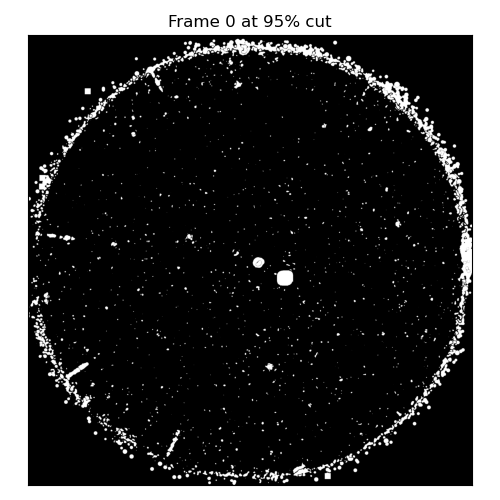

In [39]:
stack = []  # Initialize an empty list to store frames
data_stack = []
for i in tqdm(range(len(movie))):
    img = gaussian_filter(image, sigma=5) / exptime
    mov = gaussian_filter(movie[i], sigma=5) / exptimes[i]
    diff = np.abs(img - mov)
    diff[~np.isfinite(diff)] = np.nanmax(diff[np.isfinite(diff)])  # Replace non-finite values with the max finite value

    # Create a binary mask based on the 95th percentile
    threshold = 95
    binary_mask = np.array(diff > np.percentile(diff, threshold), dtype=np.uint8)
    data_stack+=[binary_mask]

    # Create a figure and axes for visualization
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    axes.imshow(binary_mask, cmap='gray', origin='lower')
    axes.set_title(f"Frame {i} at {threshold}% cut")
    axes.set_xticks([])
    axes.set_yticks([])
    plt.tight_layout()

    # Convert the figure to an image array
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # RGBA has 4 channels
    stack.append(frame[:, :, :3])  # Keep only RGB channels
    plt.close(fig)  # Close the figure to free memory

# Save the stack as a GIF
imageio.mimsave('var_qa.gif', stack, duration=0.5, loop=0)
display(Image(filename='var_qa.gif'))


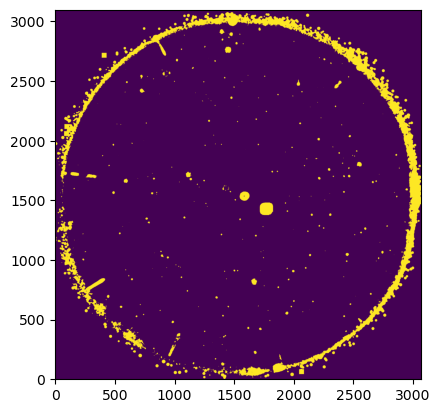

In [48]:
n = len(data_stack)
plt.imshow(np.array(np.array(data_stack).sum(axis=0)>n/4,dtype=np.uint8),origin='lower');